In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import pandas as pd
from pathlib import Path
from utils import *
from inception import *
from models import *
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import fastai
from fastai.vision import *

In [3]:
DATAPATH = Path.cwd()

In [4]:
sorted(list(DATAPATH.iterdir()))

[PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.git'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.gitignore'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.ipynb_checkpoints'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/.vscode'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/01_adiac-LBFGS-Copy1.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/01_adiac-LBFGS.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/01_adiac-inception.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/01_adiac.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/02_adiac_inception_resnet.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/02_inception.ipynb'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Adiac'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/README.md'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff'),
 PosixPath('/home/tc256760/Docum

In [5]:
task = 'Adiac'
df_train, df_test = load_df(DATAPATH, task)

In [6]:
num_classes = df_train.target.nunique(); num_classes

37

In [7]:
def process_dfs(df_train, df_test):
    x_train, y_train = df_train.values[:,:-1].astype('float'), df_train.values[:,-1].astype('int')
    x_test, y_test = df_test.values[:,:-1].astype('float'), df_test.values[:,-1].astype('int')

    x_train_mean = x_train.mean()
    x_train_std = x_train.std()

    x_train = (x_train - x_train_mean)/(x_train_std)
    x_test = (x_test - x_train_mean)/(x_train_std)

    y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(num_classes-1)
    y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(num_classes-1)
    return x_train, y_train, x_test, y_test

# DL

In [8]:
def to_TDS(x, y):
    return TensorDataset(torch.Tensor(x).unsqueeze(dim=1),  torch.Tensor(y).long())

def create_databunch(tr_ds, val_ds, bs=64):
    train_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True)
    valid_dl = DataLoader(val_ds, batch_size=bs, shuffle=True)
    return DataBunch(train_dl, valid_dl)

In [9]:
x_train, y_train, x_test, y_test = process_dfs(df_train, df_test)

In [10]:
x_train.shape, x_test.shape

((390, 176), (391, 176))

In [11]:
tr_ds, val_ds = to_TDS(x_train, y_train), to_TDS(x_test, y_test)

In [12]:
db = create_databunch(tr_ds, val_ds, 32)

Testing dims at input/output

In [13]:
tx, ty = next(iter(db.train_dl))

In [14]:
tx.shape, ty.shape

(torch.Size([32, 1, 176]), torch.Size([32]))

## Inception Time

In [15]:
InceptionModule(1, 32, use_bottleneck=False)

InceptionModule(
  (conv1): Conv1d(1, 32, kernel_size=(41,), stride=(1,), padding=(20,), bias=False)
  (conv2): Conv1d(1, 32, kernel_size=(21,), stride=(1,), padding=(10,), bias=False)
  (conv3): Conv1d(1, 32, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
  (conv_bottle): Sequential(
    (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (1): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
  )
  (bn_relu): Sequential(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [15]:
def incep_res_block_1d(nf, nb_filters, bns=32, use_bottle=False):
    "Resnet block as described in the paper."
    return SequentialEx(InceptionModule(nf, nb_filters, [9,5,3], use_bottle,  bottleneck_size=bns),
                        MergeLayer())

In [17]:
def create_inresnet(ni, nout, ks=9, conv_sizes=[64, 128, 128], stride=1): 
    "Basic 11 Layer - 1D resnet builder"
    layers = []
    sizes = zip([ni]+conv_sizes, conv_sizes)
    for n1, n2 in sizes:
            layers += [conv_layer(n1, n2, ks=ks, stride=stride),
                       incep_res_block_1d(n2)]
    return nn.Sequential(*layers, 
                         AdaptiveConcatPool1d(),
                         Flatten(),
                        *bn_drop_lin(2*n2, nout, p=0.1)
                        )

In [55]:
model = SequentialEx(incep_res_block_1d(1, 16),
                            MergeLayer(),
                            nn.ReLU(),
                            incep_res_block_1d(64, 64),
#                             MergeLayer(),
#                             nn.ReLU(),
#                             incep_res_block_1d(256, 64),
#                             MergeLayer(),
#                             nn.ReLU(),
#                             AdaptiveConcatPool1d(),
#                             Flatten(),
#                             nn.Linear(512, num_classes)
                           )
model

SequentialEx(
  (layers): ModuleList(
    (0): SequentialEx(
      (layers): ModuleList(
        (0): InceptionModule(
          (conv1): Conv1d(1, 16, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
          (conv2): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
          (conv3): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (conv_bottle): Sequential(
            (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
            (1): Conv1d(1, 16, kernel_size=(1,), stride=(1,), bias=False)
          )
          (bn_relu): Sequential(
            (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
          )
        )
        (1): MergeLayer()
      )
    )
    (1): MergeLayer()
    (2): ReLU()
    (3): SequentialEx(
      (layers): ModuleList(
        (0): InceptionModule(
          (conv1): Conv1d(64, 64, kernel_size=(9,), stride=(1

In [56]:
# model = create_inresnet(1, num_classes, conv_sizes=[64, 128, 256], stride=1)

In [57]:
# model = create_mlp(x_train[0].shape[0], num_classes)

In [58]:
# model = create_fcn(1, num_classes)

In [59]:
model.cuda()(tx).shape

RuntimeError: The size of tensor a (256) must match the size of tensor b (64) at non-singleton dimension 1

In [143]:
learn_res = fastai.basic_train.Learner(db, 
                                       model, 
                                       loss_func = CrossEntropyFlat(), 
                                       metrics=[error_rate],
                                       wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


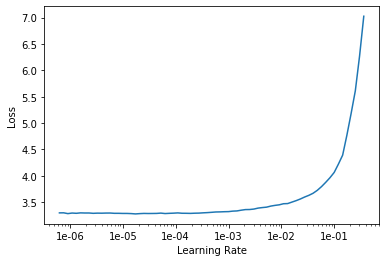

In [146]:
learn_res.lr_find(); learn_res.recorder.plot()

In [147]:
learn_res.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,3.442644,3.617229,0.913043,00:00
1,3.474258,3.629771,0.946292,00:00
2,3.545828,3.704329,0.895141,00:00
3,3.598845,3.783686,0.933504,00:00
4,3.651763,3.982157,0.946292,00:00
5,3.721321,4.223794,0.982097,00:00
6,3.815622,4.648557,0.982097,00:00
7,3.984177,4.964571,0.976982,00:00
8,4.196963,4.893186,0.982097,00:00
9,4.276759,4.748049,0.964194,00:00


In [132]:
p, t = learn_res.get_preds()

In [133]:
error_rate(p,t)

tensor(0.4297)

In [134]:
def get_cm(p, t): return confusion_matrix(t, p.softmax(dim=1).argmax(1))

Confusion Matrix

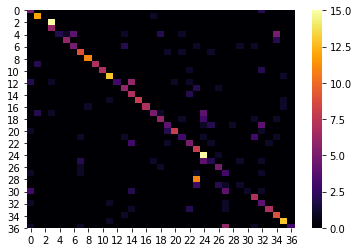

In [135]:
sns.heatmap(get_cm(p,t), cmap='inferno')